# Metrics

## Presence

Iniciando o processamento da série temporal...
Processando: savanna1990.tif...
Processando: savanna1995.tif...
Processando: savanna2000.tif...
Processando: savanna2005.tif...
Processando: savanna2010.tif...
Processando: savanna2015.tif...
Processando: savanna2020.tif...

Gerando o gráfico...


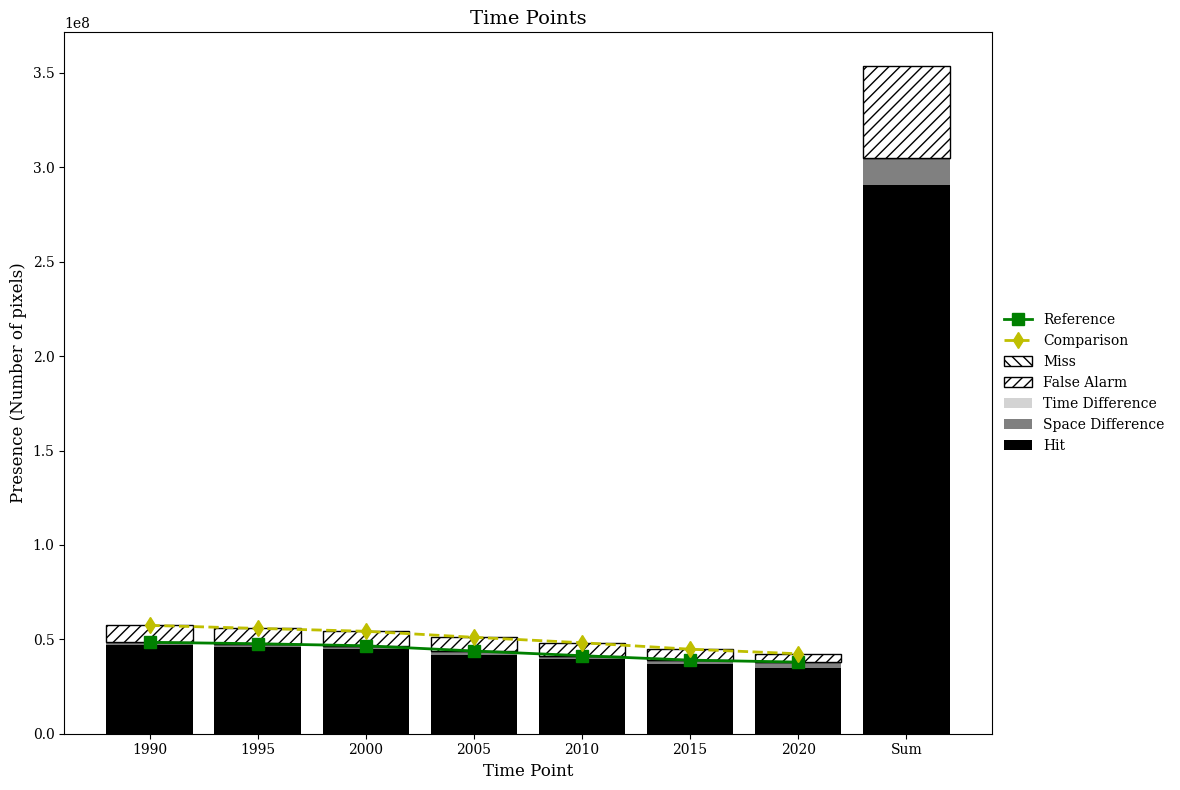


Processamento concluído. Gráfico salvo como: presence_agreement_savanna_final_ordered.png


In [1]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils import north_arrow

from pyproj import Transformer

# =============================================================================
# 1. DEFINIÇÃO DOS PARÂMETROS
# =============================================================================

# Input raster maps:
path_series_x = r"C:\Users\AntFonseca\github\compare-time-series\input\collection6"
path_series_y = r"C:\Users\AntFonseca\github\compare-time-series\input\collection8"
time_points = [1990, 1995, 2000, 2005, 2010, 2015, 2020]
class_name = "savanna"
# path_series_x = r"C:\Users\AntFonseca\github\compare-time-series\input\toydata\x"
# path_series_y = r"C:\Users\AntFonseca\github\compare-time-series\input\toydata\y"
# time_points = [0, 1, 2]
# class_name = "toydata"

# Valor que representa 'NoData' nos arquivos raster
nodata_value = 255

# =============================================================================
# 2. FUNÇÃO PARA CÁLCULO DAS MÉTRICAS DE PRESENÇA
# (Versão já corrigida da etapa anterior)
# =============================================================================

def calculate_presence_metrics(file_x, file_y):
    """
    Calcula as métricas de concordância de presença para um único ponto no tempo.
    """
    with rasterio.open(file_x) as src_x, rasterio.open(file_y) as src_y:
        array_x = src_x.read(1)
        array_y = src_y.read(1)
        valid_mask = (array_x != nodata_value) & (array_y != nodata_value)
        presence_x = array_x[valid_mask]
        presence_y = array_y[valid_mask]

        hits = np.sum(np.minimum(presence_x, presence_y))
        total_x = np.sum(presence_x)
        total_y = np.sum(presence_y)

        # --- CORREÇÃO DE OVERFLOW ---
        # Converte os totais para um tipo de inteiro com sinal (int64) antes da subtração
        # para evitar o erro de 'overflow'.
        hits = hits.astype(np.int64)
        total_x = total_x.astype(np.int64)
        total_y = total_y.astype(np.int64)
        # --- FIM DA CORREÇÃO ---

        space_difference = np.minimum(total_x, total_y) - hits
        misses = np.maximum(0, total_x - total_y)
        false_alarms = np.maximum(0, total_y - total_x)

        return {
            "Hit": hits, "Miss": misses, "False Alarm": false_alarms,
            "Space Difference": space_difference, "Total X": total_x, "Total Y": total_y
        }

# =============================================================================
# 3. PROCESSAMENTO DA SÉRIE TEMPORAL
# =============================================================================

results_by_time = {}
print("Iniciando o processamento da série temporal...")
for year in time_points:
    # Monta o nome do arquivo com base no padrão padronizado: {classe}{ano}.tif
    file_name = f"{class_name}{year}.tif"
    file_x = os.path.join(path_series_x, file_name)
    file_y = os.path.join(path_series_y, file_name)

    # Verifica se ambos os arquivos existem antes de processar
    if os.path.exists(file_x) and os.path.exists(file_y):
        print(f"Processando: {file_name}...")
        results_by_time[year] = calculate_presence_metrics(file_x, file_y)
    else:
        print(f"Aviso: Arquivo '{file_name}' não encontrado em ambas as pastas. Pulando.")

# =============================================================================
# 4. CÁLCULO DOS TOTAIS (SUM) - LÓGICA FINAL CORRIGIDA
# =============================================================================

sum_results = {
    "Hit": 0, "Space Difference": 0, "Total X": 0, "Total Y": 0
}

# Soma os componentes de Hit, Space Difference e Totais de todos os anos
for year in results_by_time:
    sum_results["Hit"] += results_by_time[year]["Hit"]
    sum_results["Space Difference"] += results_by_time[year]["Space Difference"]
    sum_results["Total X"] += results_by_time[year]["Total X"]
    sum_results["Total Y"] += results_by_time[year]["Total Y"]

# Calcula Time Difference (Equação 10)
sum_results["Time Difference"] = (
    np.minimum(sum_results["Total X"], sum_results["Total Y"])
    - sum_results["Hit"]
    - sum_results["Space Difference"]
)

# --- CORREÇÃO FINAL APLICADA AQUI ---
# Calcula Miss e False Alarm para a barra "Sum" com base nos totais gerais.
# Um desses valores será sempre zero. (Equações 11 e 12)

sum_results["Miss"] = np.maximum(0, sum_results["Total X"] - sum_results["Total Y"])
sum_results["False Alarm"] = np.maximum(0, sum_results["Total Y"] - sum_results["Total X"])
# --- FIM DA CORREÇÃO FINAL ---

# =============================================================================
# 5. GERAÇÃO DO GRÁFICO
# =============================================================================
print("\nGerando o gráfico...")

mpl.rcParams['font.family'] = 'serif'

labels = [str(tp) for tp in time_points] + ["Sum"]

# Dados para as barras e linhas
hits = [results_by_time.get(tp, {}).get("Hit", 0) for tp in time_points] + [sum_results["Hit"]]
space_diff = [results_by_time.get(tp, {}).get("Space Difference", 0) for tp in time_points] + [sum_results["Space Difference"]]
time_diff = [0] * len(time_points) + [sum_results["Time Difference"]]
misses = [results_by_time.get(tp, {}).get("Miss", 0) for tp in time_points] + [sum_results["Miss"]]
false_alarms = [results_by_time.get(tp, {}).get("False Alarm", 0) for tp in time_points] + [sum_results["False Alarm"]]

reference_line = [results_by_time.get(tp, {}).get("Total X", 0) for tp in time_points]
comparison_line = [results_by_time.get(tp, {}).get("Total Y", 0) for tp in time_points]

fig, ax = plt.subplots(figsize=(14, 8))

# --- Plotagem dos elementos ---
bottom = np.zeros(len(labels))
ax.bar(labels, hits, label='Hit', color='black', bottom=bottom); bottom += np.array(hits)
ax.bar(labels, space_diff, label='Space Difference', color='grey', bottom=bottom); bottom += np.array(space_diff)
ax.bar(labels, time_diff, label='Time Difference', color='lightgray', bottom=bottom); bottom += np.array(time_diff)
ax.bar(labels, misses, label='Miss', color='white', edgecolor='black', hatch='\\\\\\', bottom=bottom); bottom += np.array(misses)
ax.bar(labels, false_alarms, label='False Alarm', color='white', edgecolor='black', hatch='///', bottom=bottom)

ax.plot(labels[:-1], reference_line, 's-g', label='Reference', linewidth=2, markersize=8)
ax.plot(labels[:-1], comparison_line, 'd--y', label='Comparison', linewidth=2, markersize=8)


# --- LÓGICA PARA ORDENAR A LEGENDA ---
# 1. Pega todos os handles e labels que foram plotados
handles, labels = ax.get_legend_handles_labels()

# 2. Define a ordem desejada para os labels (com a correção)
order = ["Reference", "Comparison", "Miss", "False Alarm", "Time Difference", "Space Difference", "Hit"]

# 3. Cria um dicionário para mapear labels aos seus handles
legend_dict = dict(zip(labels, handles))

# 4. Reorganiza os handles e labels de acordo com a lista 'order'
ordered_handles = [legend_dict[label] for label in order]
ordered_labels = order

# 5. Cria a legenda com os itens já ordenados
ax.legend(ordered_handles, ordered_labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
# --- FIM DA LÓGICA DE ORDENAÇÃO ---

ax.set_title('Time Points', fontsize=14)
ax.set_xlabel('Time Point', fontsize=12)
ax.set_ylabel('Presence (Number of pixels)', fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])

output_filename = f'presence_agreement_{class_name}_final_ordered.png'
plt.savefig(output_filename, dpi=300)

plt.show()

print(f"\nProcessamento concluído. Gráfico salvo como: {output_filename}")

## Gross Change

✅ Iniciando a Célula de Cálculo de Ganhos e Perdas.
Calculando métricas de mudança para cada intervalo...
Processando intervalo: 1990-1995...
Lendo do disco: savanna1995.tif...
Lendo do disco: savanna1990.tif...
Processando intervalo: 1995-2000...
Lendo do disco: savanna2000.tif...
Processando intervalo: 2000-2005...
Lendo do disco: savanna2005.tif...
Processando intervalo: 2005-2010...
Lendo do disco: savanna2010.tif...
Processando intervalo: 2010-2015...
Lendo do disco: savanna2015.tif...
Processando intervalo: 2015-2020...
Lendo do disco: savanna2020.tif...
Calculando métricas para a Extensão Temporal...

Gerando o gráfico de Ganhos e Perdas...


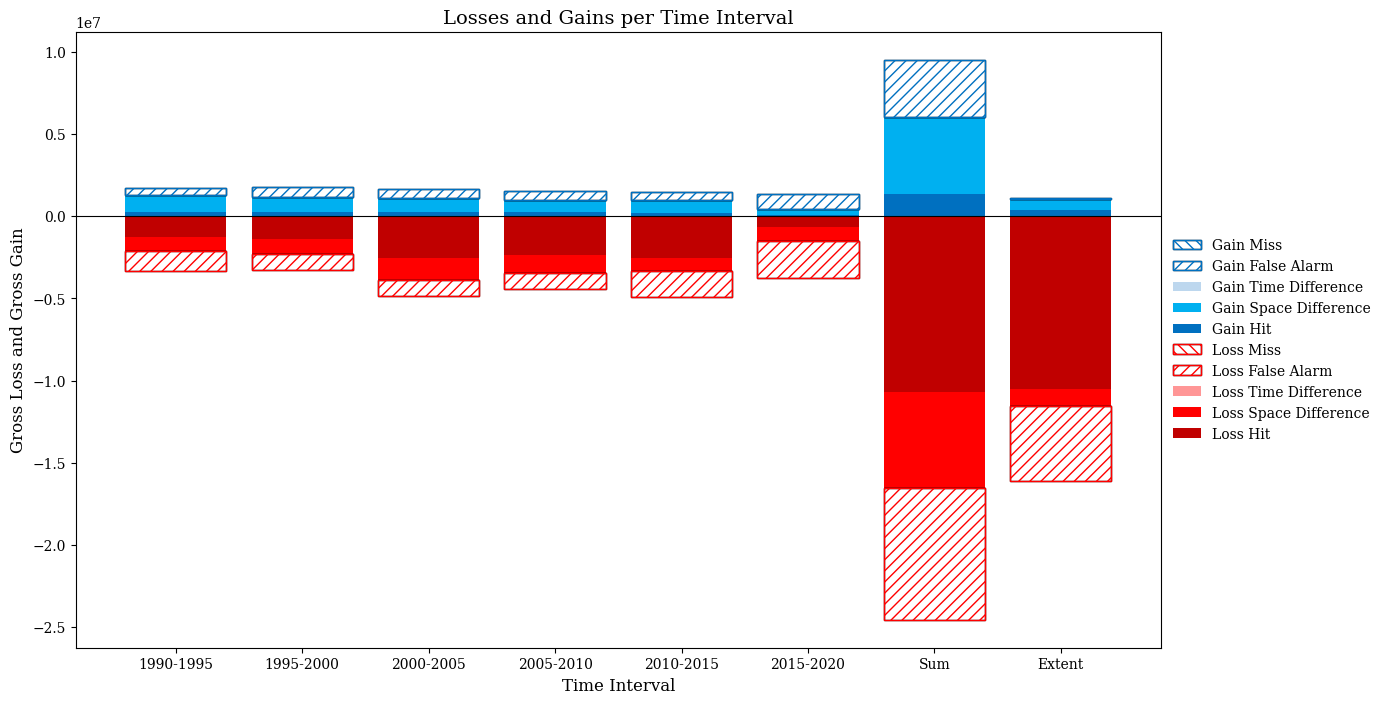


Processamento concluído. Gráfico salvo como: change_agreement_savanna.png


In [2]:
# =============================================================================
# NOVA CÉLULA: Ganhos e Perdas Brutos por Intervalo de Tempo (Versão Final com Extent)
# =============================================================================
print("✅ Iniciando a Célula de Cálculo de Ganhos e Perdas.")

# Dicionário para armazenar os arrays de raster e evitar releituras nesta célula
raster_arrays = {}

def get_raster_array(year):
    """
    Lê um par de arquivos raster (x e y) para um dado ano ou o retorna 
    do cache se já tiver sido lido anteriormente nesta célula.
    """
    if year in raster_arrays:
        return raster_arrays[year]
    
    file_name = f"{class_name}{year}.tif"
    path_x = os.path.join(path_series_x, file_name)
    path_y = os.path.join(path_series_y, file_name)

    if not os.path.exists(path_x) or not os.path.exists(path_y):
        print(f"Aviso: Arquivo '{file_name}' não encontrado para o ano {year}.")
        return None, None

    print(f"Lendo do disco: {file_name}...")
    with rasterio.open(path_x) as src_x, rasterio.open(path_y) as src_y:
        array_x = src_x.read(1)
        array_y = src_y.read(1)
        # Armazena os arrays no cache para uso futuro nesta célula
        raster_arrays[year] = (array_x, array_y)
        return array_x, array_y

# =============================================================================
# 1. FUNÇÕES DE CÁLCULO DE MÉTRICAS
# =============================================================================

def calculate_change_metrics(year_t, year_t_minus_1):
    array_x_t, array_y_t = get_raster_array(year_t)
    array_x_t_minus_1, array_y_t_minus_1 = get_raster_array(year_t_minus_1)
    if array_x_t is None or array_x_t_minus_1 is None: return None
    valid_mask = (array_x_t != nodata_value) & (array_y_t != nodata_value) & \
                 (array_x_t_minus_1 != nodata_value) & (array_y_t_minus_1 != nodata_value)
    px_t, py_t = array_x_t[valid_mask].astype(np.int64), array_y_t[valid_mask].astype(np.int64)
    px_t_minus_1, py_t_minus_1 = array_x_t_minus_1[valid_mask].astype(np.int64), array_y_t_minus_1[valid_mask].astype(np.int64)
    gain_x, gain_y = np.maximum(0, px_t - px_t_minus_1), np.maximum(0, py_t - py_t_minus_1)
    gain_total_x, gain_total_y = np.sum(gain_x), np.sum(gain_y)
    gain_hit = np.sum(np.minimum(gain_x, gain_y))
    gain_space_diff = np.minimum(gain_total_x, gain_total_y) - gain_hit
    gain_miss = np.maximum(0, gain_total_x - gain_total_y)
    gain_false_alarm = np.maximum(0, gain_total_y - gain_total_x)
    loss_x, loss_y = np.minimum(0, px_t - px_t_minus_1), np.minimum(0, py_t - py_t_minus_1)
    loss_total_x, loss_total_y = np.sum(loss_x), np.sum(loss_y)
    loss_hit = np.sum(np.maximum(loss_x, loss_y))
    loss_space_diff = np.maximum(loss_total_x, loss_total_y) - loss_hit
    loss_miss = np.minimum(0, loss_total_x - loss_total_y)
    loss_false_alarm = np.minimum(0, loss_total_y - loss_total_x)
    return {"Gain Hit": gain_hit, "Gain Miss": gain_miss, "Gain False Alarm": gain_false_alarm, "Gain Space Difference": gain_space_diff,
            "Loss Hit": loss_hit, "Loss Miss": loss_miss, "Loss False Alarm": loss_false_alarm, "Loss Space Difference": loss_space_diff,
            "Gain Total X": gain_total_x, "Gain Total Y": gain_total_y, "Loss Total X": loss_total_x, "Loss Total Y": loss_total_y}

def calculate_extent_metrics(time_points_list):
    """
    Calcula as métricas de ganho e perda para a extensão temporal total.
    """
    start_year, end_year = time_points_list[0], time_points_list[-1]
    array_x_start, array_y_start = get_raster_array(start_year)
    array_x_end, array_y_end = get_raster_array(end_year)
    if array_x_start is None or array_x_end is None: return None
    valid_mask = (array_x_start != nodata_value) & (array_y_start != nodata_value) & \
                 (array_x_end != nodata_value) & (array_y_end != nodata_value)
    px_start, py_start = array_x_start[valid_mask].astype(np.int64), array_y_start[valid_mask].astype(np.int64)
    px_end, py_end = array_x_end[valid_mask].astype(np.int64), array_y_end[valid_mask].astype(np.int64)
    gain_x, gain_y = np.maximum(0, px_end - px_start), np.maximum(0, py_end - py_start)
    gain_total_x, gain_total_y = np.sum(gain_x), np.sum(gain_y)
    gain_hit = np.sum(np.minimum(gain_x, gain_y))
    gain_space_diff = np.minimum(gain_total_x, gain_total_y) - gain_hit
    gain_miss = np.maximum(0, gain_total_x - gain_total_y)
    gain_false_alarm = np.maximum(0, gain_total_y - gain_total_x)
    loss_x, loss_y = np.minimum(0, px_end - px_start), np.minimum(0, py_end - py_start)
    loss_total_x, loss_total_y = np.sum(loss_x), np.sum(loss_y)
    loss_hit = np.sum(np.maximum(loss_x, loss_y))
    loss_space_diff = np.maximum(loss_total_x, loss_total_y) - loss_hit
    loss_miss = np.minimum(0, loss_total_x - loss_total_y)
    loss_false_alarm = np.minimum(0, loss_total_y - loss_total_x)
    return {"Gain Hit": gain_hit, "Gain Miss": gain_miss, "Gain False Alarm": gain_false_alarm, "Gain Space Difference": gain_space_diff,
            "Loss Hit": loss_hit, "Loss Miss": loss_miss, "Loss False Alarm": loss_false_alarm, "Loss Space Difference": loss_space_diff}

# =============================================================================
# 2. PROCESSAMENTO DOS INTERVALOS E DO EXTENT
# =============================================================================
change_results_by_interval = {}
time_intervals = []
print("Calculando métricas de mudança para cada intervalo...")
for i in range(1, len(time_points)):
    year_t, year_t_minus_1 = time_points[i], time_points[i-1]
    interval_label = f"{year_t_minus_1}-{year_t}"
    time_intervals.append(interval_label)
    print(f"Processando intervalo: {interval_label}...")
    change_results_by_interval[interval_label] = calculate_change_metrics(year_t, year_t_minus_1)

print("Calculando métricas para a Extensão Temporal...")
extent_results = calculate_extent_metrics(time_points)

# =============================================================================
# 3. CÁLCULO DOS TOTAIS (SUM) PARA MUDANÇA
# =============================================================================
sum_change_results = { "Gain Hit": 0, "Gain Space Difference": 0, "Gain Total X": 0, "Gain Total Y": 0, "Gain Time Difference": 0, "Loss Hit": 0, "Loss Space Difference": 0, "Loss Total X": 0, "Loss Total Y": 0, "Loss Time Difference": 0, }
for interval in time_intervals:
    results = change_results_by_interval[interval]
    if results:
        for key in ["Gain Hit", "Gain Space Difference", "Gain Total X", "Gain Total Y", "Loss Hit", "Loss Space Difference", "Loss Total X", "Loss Total Y"]:
            sum_change_results[key] += results[key]
sum_change_results["Gain Time Difference"] = np.minimum(sum_change_results["Gain Total X"], sum_change_results["Gain Total Y"]) - sum_change_results["Gain Hit"] - sum_change_results["Gain Space Difference"]
sum_change_results["Gain Miss"] = np.maximum(0, sum_change_results["Gain Total X"] - sum_change_results["Gain Total Y"])
sum_change_results["Gain False Alarm"] = np.maximum(0, sum_change_results["Gain Total Y"] - sum_change_results["Gain Total X"])
sum_change_results["Loss Time Difference"] = np.maximum(sum_change_results["Loss Total X"], sum_change_results["Loss Total Y"]) - sum_change_results["Loss Hit"] - sum_change_results["Loss Space Difference"]
sum_change_results["Loss Miss"] = np.minimum(0, sum_change_results["Loss Total X"] - sum_change_results["Loss Total Y"])
sum_change_results["Loss False Alarm"] = np.minimum(0, sum_change_results["Loss Total Y"] - sum_change_results["Loss Total X"])

# Importa a biblioteca de patches do Matplotlib, necessária para criar a legenda customizada
import matplotlib.patches as mpatches

# =============================================================================
# 4. GERAÇÃO DO GRÁFICO DE GANHOS E PERDAS (LEGENDA CORRIGIDA)
# =============================================================================
print("\nGerando o gráfico de Ganhos e Perdas...")

labels = time_intervals + ["Sum", "Extent"]

gain_colors = {
    'Hit': '#0070C0',
    'Space Difference': '#00B0F0',
    'Time Difference': '#BDD7EE',
    'Miss': 'white',
    'False Alarm': 'white'
}
loss_colors = {
    'Hit': '#C00000',
    'Space Difference': '#FF0000',
    'Time Difference': '#FF9696',
    'Miss': 'white',
    'False Alarm': 'white'
}

gain_hatch_color = '#0070C0'
loss_hatch_color = '#FF0000'

fig, ax = plt.subplots(figsize=(14, 8))
mpl.rcParams['font.family'] = 'serif'

# --- Plotagem dos Ganhos (Lógica inalterada) ---
bottom_gain = np.zeros(len(labels))
for comp in ["Hit", "Space Difference", "Time Difference", "Miss", "False Alarm"]:
    data = [change_results_by_interval.get(interval, {}).get(f"Gain {comp}", 0) for interval in time_intervals]
    data.append(sum_change_results.get(f"Gain {comp}", 0))
    data.append(extent_results.get(f"Gain {comp}", 0))
    if comp == "Time Difference": data[-1] = 0
    if comp in ["Miss", "False Alarm"]:
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(labels, data, label=f'Gain {comp}', color='white', bottom=bottom_gain, edgecolor='black')
        ax.bar(labels, data, color='none', bottom=bottom_gain, edgecolor=gain_hatch_color, hatch=hatch)
    else:
        ax.bar(labels, data, label=f'Gain {comp}', color=gain_colors[comp], bottom=bottom_gain, edgecolor='none')
    bottom_gain += np.array(data)

# --- Plotagem das Perdas (Lógica inalterada) ---
bottom_loss = np.zeros(len(labels))
for comp in ["Hit", "Space Difference", "Time Difference", "Miss", "False Alarm"]:
    data = [change_results_by_interval.get(interval, {}).get(f"Loss {comp}", 0) for interval in time_intervals]
    data.append(sum_change_results.get(f"Loss {comp}", 0))
    data.append(extent_results.get(f"Loss {comp}", 0))
    if comp == "Time Difference": data[-1] = 0
    if comp in ["Miss", "False Alarm"]:
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(labels, data, label=f'Loss {comp}', color='white', bottom=bottom_loss, edgecolor='black')
        ax.bar(labels, data, color='none', bottom=bottom_loss, edgecolor=loss_hatch_color, hatch=hatch)
    else:
        ax.bar(labels, data, label=f'Loss {comp}', color=loss_colors[comp], bottom=bottom_loss, edgecolor='none')
    bottom_loss += np.array(data)

# --- Configurações Finais do Gráfico ---
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Losses and Gains per Time Interval', fontsize=14)
ax.set_xlabel('Time Interval', fontsize=12)
ax.set_ylabel('Gross Loss and Gross Gain', fontsize=12)

# --- LÓGICA PARA ORDENAR A LEGENDA (COM CORREÇÃO DOS HANDLES) ---
handles, labels_list = ax.get_legend_handles_labels()
legend_dict = dict(zip(labels_list, handles))

# --- CRIAÇÃO DOS HANDLES PERSONALIZADOS PARA A LEGENDA ---
# Para cada item hachurado, criamos uma legenda que é uma tupla de dois patches:
# a base branca/borda preta + a hachura colorida/fundo transparente.
legend_dict['Gain Miss'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='\\\\\\')
)
legend_dict['Gain False Alarm'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='///')
)
legend_dict['Loss Miss'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='\\\\\\')
)
legend_dict['Loss False Alarm'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='///')
)

order = [
    'Gain Miss', 'Gain False Alarm', 'Gain Time Difference', 'Gain Space Difference', 'Gain Hit',
    'Loss Miss', 'Loss False Alarm', 'Loss Time Difference', 'Loss Space Difference', 'Loss Hit'
]
ordered_handles = [legend_dict[label] for label in order]
ordered_labels = order

ax.legend(
    handles=ordered_handles,
    labels=ordered_labels,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False
)

output_filename = f'change_agreement_{class_name}.png'
plt.savefig(
    output_filename,
    dpi=300
)

plt.show()

print(f"\nProcessamento concluído. Gráfico salvo como: {output_filename}")

## Net Change

✅ Iniciando a Célula de Gráfico de Mudança Líquida (Baseado nas Equações).
Calculando os componentes de Mudança Líquida para cada intervalo...
Calculando os componentes de Mudança Líquida para a Extensão...
Calculando os componentes de Mudança Líquida para a Soma...

Gerando o gráfico de Mudança Líquida...


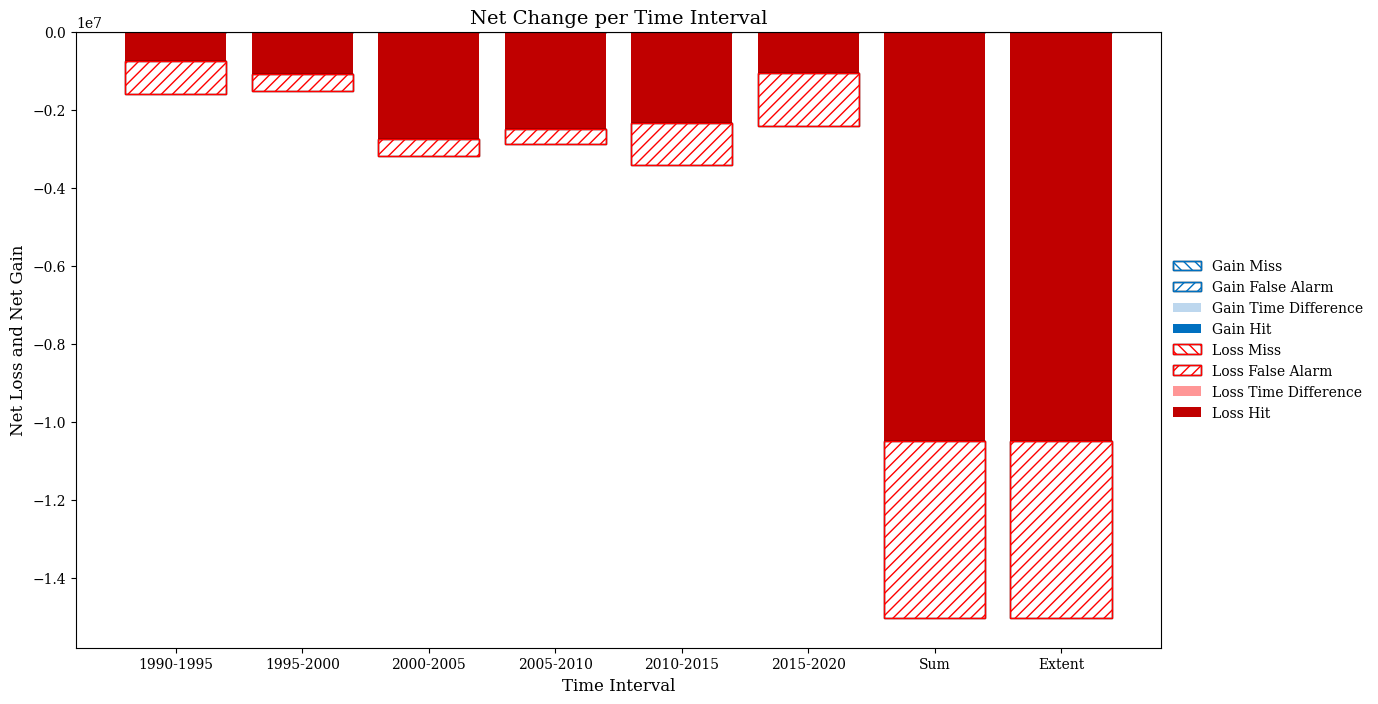


Processamento concluído. Gráfico de Mudança Líquida salvo como: net_change_agreement_savanna.png


In [3]:
# =============================================================================
# NOVA CÉLULA: Gráfico de Mudança Líquida (Net Change) - Versão Final
# =============================================================================
print("✅ Iniciando a Célula de Gráfico de Mudança Líquida (Baseado nas Equações).")

# Importa a biblioteca de patches, caso a célula seja executada de forma independente
import matplotlib.patches as mpatches

# =============================================================================
# 1. FUNÇÃO PARA CÁLCULO DOS COMPONENTES DE MUDANÇA LÍQUIDA
# =============================================================================

def calculate_net_change_components(gross_results):
    """
    Calcula os componentes de Net Change a partir dos resultados de Gross Change,
    seguindo as equações 41-48 do artigo.
    """
    if not gross_results:
        return None

    # --- Passo 1: Calcular Quantity Gain e Quantity Loss (Eqs. 41-44) ---
    Ght, Gut, Gmt, Gft = gross_results["Gain Hit"], gross_results["Gain Space Difference"], gross_results["Gain Miss"], gross_results["Gain False Alarm"]
    Lht, Lut, Lmt, Lft = gross_results["Loss Hit"], gross_results["Loss Space Difference"], gross_results["Loss Miss"], gross_results["Loss False Alarm"]

    QGxt = np.maximum(0, Ght + Gut + Gmt + Lht + Lut + Lmt)
    QGyt = np.maximum(0, Ght + Gut + Gft + Lht + Lut + Lft)
    QLxt = np.minimum(0, Ght + Gut + Gmt + Lht + Lut + Lmt)
    QLyt = np.minimum(0, Ght + Gut + Gft + Lht + Lut + Lft)

    # --- Passo 2: Calcular os componentes de Net Change ---
    net_gain_hit = np.minimum(QGxt, QGyt)
    net_gain_miss = np.maximum(0, QGxt - QGyt)
    net_gain_false_alarm = np.maximum(0, QGyt - QGxt)
    net_loss_hit = np.maximum(QLxt, QLyt)
    net_loss_miss = np.minimum(0, QLxt - QLyt)
    net_loss_false_alarm = np.minimum(0, QLyt - QLxt)
    
    return {
        "Gain Hit": net_gain_hit, "Gain Miss": net_gain_miss, "Gain False Alarm": net_gain_false_alarm,
        "Loss Hit": net_loss_hit, "Loss Miss": net_loss_miss, "Loss False Alarm": net_loss_false_alarm,
        "QG_Total_X": QGxt, "QG_Total_Y": QGyt, "QL_Total_X": QLxt, "QL_Total_Y": QLyt
    }

# =============================================================================
# 2. PROCESSAMENTO PARA OBTER OS COMPONENTES DE NET CHANGE
# =============================================================================
net_change_by_interval = {}
print("Calculando os componentes de Mudança Líquida para cada intervalo...")
for interval_label, gross_results in change_results_by_interval.items():
    net_change_by_interval[interval_label] = calculate_net_change_components(gross_results)

print("Calculando os componentes de Mudança Líquida para a Extensão...")
net_extent_results = calculate_net_change_components(extent_results)

# =============================================================================
# 3. CÁLCULO DOS TOTAIS (SUM) PARA NET CHANGE - LÓGICA CORRIGIDA
# =============================================================================
print("Calculando os componentes de Mudança Líquida para a Soma...")
sum_net_results = { 
    "QG_Total_X": 0, "QG_Total_Y": 0, "QL_Total_X": 0, "QL_Total_Y": 0,
    "Gain Hit": 0, "Loss Hit": 0 # Inicializa os hits da soma
}
# Primeiro, acumula os totais de QG, QL e os HITS de cada intervalo
for interval, results in net_change_by_interval.items():
    if results:
        sum_net_results["QG_Total_X"] += results["QG_Total_X"]
        sum_net_results["QG_Total_Y"] += results["QG_Total_Y"]
        sum_net_results["QL_Total_X"] += results["QL_Total_X"]
        sum_net_results["QL_Total_Y"] += results["QL_Total_Y"]
        # Acumula os hits dos intervalos para obter o Hit da barra SUM
        sum_net_results["Gain Hit"] += results["Gain Hit"]
        sum_net_results["Loss Hit"] += results["Loss Hit"]

# Agora, calcula os componentes finais para a barra SUM
# Miss e False Alarm são calculados a partir dos totais de quantidade
sum_net_results["Gain Miss"] = np.maximum(0, sum_net_results["QG_Total_X"] - sum_net_results["QG_Total_Y"])
sum_net_results["Gain False Alarm"] = np.maximum(0, sum_net_results["QG_Total_Y"] - sum_net_results["QG_Total_X"])
sum_net_results["Loss Miss"] = np.minimum(0, sum_net_results["QL_Total_X"] - sum_net_results["QL_Total_Y"])
sum_net_results["Loss False Alarm"] = np.minimum(0, sum_net_results["QL_Total_Y"] - sum_net_results["QL_Total_X"])

# Time Difference é o que sobra da concordância de quantidade depois de subtrair a soma dos hits
sum_net_results["Gain Time Difference"] = np.minimum(sum_net_results["QG_Total_X"], sum_net_results["QG_Total_Y"]) - sum_net_results["Gain Hit"]
sum_net_results["Loss Time Difference"] = np.maximum(sum_net_results["QL_Total_X"], sum_net_results["QL_Total_Y"]) - sum_net_results["Loss Hit"]

# =============================================================================
# 4. GERAÇÃO DO GRÁFICO DE MUDANÇA LÍQUIDA
# =============================================================================
print("\nGerando o gráfico de Mudança Líquida...")
labels = time_intervals + ["Sum", "Extent"]
gain_colors = {'Hit': '#0070C0', 'Time Difference': '#BDD7EE', 'Miss': 'white', 'False Alarm': 'white'}
loss_colors = {'Hit': '#C00000', 'Time Difference': '#FF9696', 'Miss': 'white', 'False Alarm': 'white'}
gain_hatch_color, loss_hatch_color = '#0070C0', '#FF0000'

fig, ax = plt.subplots(figsize=(14, 8))
mpl.rcParams['font.family'] = 'serif'

# --- Plotagem dos Ganhos Líquidos ---
bottom_gain = np.zeros(len(labels))
for comp in ["Hit", "Time Difference", "Miss", "False Alarm"]:
    data = [net_change_by_interval.get(interval, {}).get(f"Gain {comp}", 0) for interval in time_intervals]
    data.append(sum_net_results.get(f"Gain {comp}", 0))
    data.append(net_extent_results.get(f"Gain {comp}", 0) if comp != "Time Difference" else 0)
    
    hatch = '///' if comp == 'False Alarm' else '\\\\\\' if comp == 'Miss' else None
    if hatch:
        ax.bar(labels, data, label=f'Gain {comp}', color='white', bottom=bottom_gain, edgecolor='black')
        ax.bar(labels, data, color='none', bottom=bottom_gain, edgecolor=gain_hatch_color, hatch=hatch)
    else:
        ax.bar(labels, data, label=f'Gain {comp}', color=gain_colors[comp], bottom=bottom_gain, edgecolor='none')
    bottom_gain += np.array(data)

# --- Plotagem das Perdas Líquidas ---
bottom_loss = np.zeros(len(labels))
for comp in ["Hit", "Time Difference", "Miss", "False Alarm"]:
    data = [net_change_by_interval.get(interval, {}).get(f"Loss {comp}", 0) for interval in time_intervals]
    data.append(sum_net_results.get(f"Loss {comp}", 0))
    data.append(net_extent_results.get(f"Loss {comp}", 0) if comp != "Time Difference" else 0)
    
    hatch = '///' if comp == 'False Alarm' else '\\\\\\' if comp == 'Miss' else None
    if hatch:
        ax.bar(labels, data, label=f'Loss {comp}', color='white', bottom=bottom_loss, edgecolor='black')
        ax.bar(labels, data, color='none', bottom=bottom_loss, edgecolor=loss_hatch_color, hatch=hatch)
    else:
        ax.bar(labels, data, label=f'Loss {comp}', color=loss_colors[comp], bottom=bottom_loss, edgecolor='none')
    bottom_loss += np.array(data)

# --- Configurações Finais ---
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Net Change per Time Interval', fontsize=14)
ax.set_xlabel('Time Interval', fontsize=12)
ax.set_ylabel('Net Loss and Net Gain', fontsize=12)

handles, labels_list = ax.get_legend_handles_labels()
legend_dict = dict(zip(labels_list, handles))
legend_dict['Gain Miss'] = (mpatches.Patch(facecolor='white', edgecolor='black'), mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='\\\\\\'))
legend_dict['Gain False Alarm'] = (mpatches.Patch(facecolor='white', edgecolor='black'), mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='///'))
legend_dict['Loss Miss'] = (mpatches.Patch(facecolor='white', edgecolor='black'), mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='\\\\\\'))
legend_dict['Loss False Alarm'] = (mpatches.Patch(facecolor='white', edgecolor='black'), mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='///'))
order = ['Gain Miss', 'Gain False Alarm', 'Gain Time Difference', 'Gain Hit', 'Loss Miss', 'Loss False Alarm', 'Loss Time Difference', 'Loss Hit']
ordered_handles = [legend_dict.get(label) for label in order]
ordered_labels = order

ax.legend(handles=ordered_handles, labels=ordered_labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
output_filename = f'net_change_agreement_{class_name}.png'
plt.savefig(output_filename, dpi=300)
plt.show()

print(f"\nProcessamento concluído. Gráfico de Mudança Líquida salvo como: {output_filename}")

# Maps

## Presence Agreement

Iniciando a Célula de Geração de Mapa de Concordância de Presença (An).
Mapa acumulador 'An' inicializado com dimensões: 20480x10240.

Iniciando o cálculo pixel a pixel para cada ponto no tempo...
Processando: savanna1990.tif...
Processando: savanna1995.tif...
Processando: savanna2000.tif...
Processando: savanna2005.tif...
Processando: savanna2010.tif...
Processando: savanna2015.tif...
Processando: savanna2020.tif...
✅
Salvando o mapa final como: map_An_presence_agreement_savanna.tif
Gerando mapa...


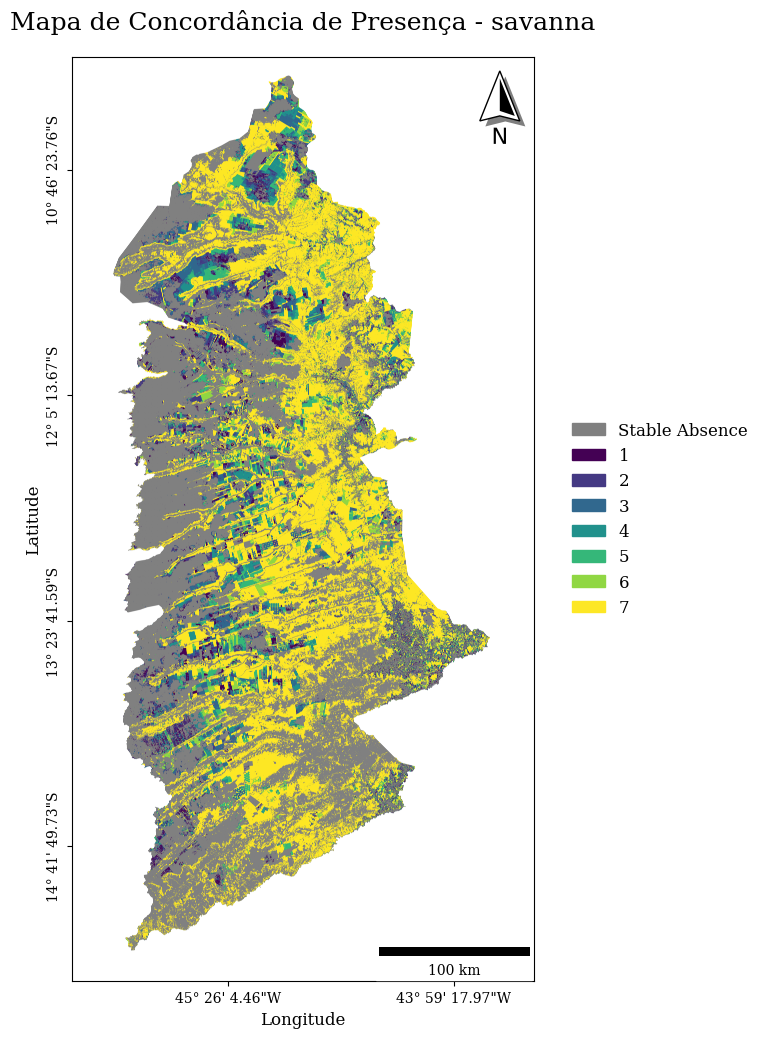

In [5]:
# =============================================================================
# NOVA CÉLULA: Mapa de Concordância de Presença Acumulada (An) - Versão Final
# =============================================================================
print("Iniciando a Célula de Geração de Mapa de Concordância de Presença (An).")

# =============================================================================
# 1. PREPARAÇÃO DO MAPA ACUMULADOR (Lógica inalterada)
# =============================================================================

first_year = time_points[0]
first_file_name = f"{class_name}{first_year}.tif"
path_to_first_file = os.path.join(path_series_x, first_file_name)

try:
    with rasterio.open(path_to_first_file) as src:
        profile = src.profile
        height, width = src.height, src.width
        An_map = np.zeros((height, width), dtype=np.float32)
        print(f"Mapa acumulador 'An' inicializado com dimensões: {height}x{width}.")
except FileNotFoundError:
    print(f"ERRO: Não foi possível encontrar o arquivo de referência '{path_to_first_file}' para inicializar o mapa.")
    An_map = None

# =============================================================================
# 2. CÁLCULO E ACUMULAÇÃO DOS HITS DE PRESENÇA (Lógica inalterada)
# =============================================================================

if An_map is not None:
    print("\nIniciando o cálculo pixel a pixel para cada ponto no tempo...")
    final_nodata_mask = np.ones_like(An_map, dtype=bool)

    for year in time_points:
        file_name = f"{class_name}{year}.tif"
        path_x = os.path.join(path_series_x, file_name)
        path_y = os.path.join(path_series_y, file_name)

        if os.path.exists(path_x) and os.path.exists(path_y):
            print(f"Processando: {file_name}...")
            with rasterio.open(path_x) as src_x, rasterio.open(path_y) as src_y:
                array_x = src_x.read(1)
                array_y = src_y.read(1)
                
                Phtn_map = np.minimum(array_x, array_y)
                valid_mask = (array_x != nodata_value) & (array_y != nodata_value)
                An_map[valid_mask] += Phtn_map[valid_mask]
                
                final_nodata_mask &= ~valid_mask
        else:
            print(f"Aviso: Arquivos para o ano {year} não encontrados. Pulando.")
            
    An_map[final_nodata_mask] = nodata_value

# =============================================================================
# 3. SALVAR E EXIBIR O MAPA FINAL (VERSÃO FINAL COM CORREÇÕES)
# =============================================================================

if An_map is not None:
    profile.update(dtype=rasterio.float32, nodata=nodata_value)
    output_filename_map = f'map_An_presence_agreement_{class_name}.tif'
    print(f"✅\nSalvando o mapa final como: {output_filename_map}")
    with rasterio.open(output_filename_map, 'w', **profile) as dst:
        dst.write(An_map, 1)

    print("Gerando mapa...")
    
    # --- Importações necessárias ---
    from matplotlib.ticker import FuncFormatter
    from pyproj import Transformer
    from matplotlib_scalebar.scalebar import ScaleBar
    from matplotlib_map_utils import north_arrow

    # --- Preparação dos Dados e Metadados para o Mapa ---
    with rasterio.open(output_filename_map) as src:
        bounds = src.bounds
        src_crs = src.crs
        transform = src.transform
        transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)
        data = src.read(1)
        masked_map = np.ma.masked_equal(data, nodata_value)
    
    # --- Lógica de Cores e Legenda Discreta (inalterada) ---
    num_time_points = len(time_points)
    viridis_colors = plt.get_cmap('viridis', num_time_points)
    colors = ['gray'] + [viridis_colors(i / (num_time_points - 1)) for i in range(num_time_points)]
    boundaries = list(range(num_time_points + 2))
    cmap = ListedColormap(colors)
    cmap.set_bad(color='white')
    norm = BoundaryNorm(boundaries, cmap.N)

    # --- Funções para Formatar os Ticks (inalterada) ---
    def format_x_ticks(x, pos):
        lon, _ = transformer.transform(x, bounds.bottom)
        deg = int(abs(lon))
        min_val = int((abs(lon) - deg) * 60)
        sec = ((abs(lon) - deg) * 60 - min_val) * 60
        return f"{deg}° {min_val}' {sec:.2f}\"" + ("E" if lon >= 0 else "W")

    def format_y_ticks(y, pos):
        _, lat = transformer.transform(bounds.left, y)
        deg = int(abs(lat))
        min_val = int((abs(lat) - deg) * 60)
        sec = ((abs(lat) - deg) * 60 - min_val) * 60
        return f"{deg}° {min_val}' {sec:.2f}\"" + ("N" if lat >= 0 else "S")

    # --- Geração do Gráfico ---
    fig, ax = plt.subplots(figsize=(14, 12))
    mpl.rcParams['font.family'] = 'serif'
    
    im = ax.imshow(masked_map, cmap=cmap, norm=norm, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    
    ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    ax.tick_params(axis='x', which='major', labelsize=10, pad=4)
    ax.tick_params(axis='y', which='major', labelsize=10, pad=4)
    plt.setp(ax.get_yticklabels(), rotation=90, va='center')
    
    # Add north arrow
    north_arrow(ax,
                location="upper right",
                rotation={"degrees": 0})

    # Add scale bar
    def km_to_degrees(value, dimension):
        approx_deg = value / 111  # Approximate conversion: 1° ≈ 111km
        return f"{approx_deg:.1f}°"

    scalebar = ScaleBar(
        1/1000,
        units='km',
        length_fraction=0.4,
        location='lower right',
        scale_formatter=lambda value, _: f"{int(value)} km"
    )
    ax.add_artist(scalebar)

    # --- Cria a Legenda Discreta ---
    labels_legenda = [f'Stable Absence'] + [f'{i}' for i in range(1, num_time_points + 1)]
    patches = [mpatches.Patch(color=colors[i], label=labels_legenda[i]) for i in range(len(labels_legenda))]
    ax.legend(
        handles=patches,
        loc='center left',
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
        fontsize=12
    )
    
    # --- Ajustes Finais ---
    ax.set_aspect('equal')
    ax.set_title(f'Mapa de Concordância de Presença - {class_name}',
                 fontsize=18,
                 pad=20)
    ax.set_xlabel('Longitude',
                  fontsize=12)
    ax.set_ylabel('Latitude',
                  fontsize=12)
    
    plt.show()

## Presence Difference

Iniciando a Célula de Geração de Mapa de Diferença de Presença (Dn).
Mapa acumulador 'Dn' inicializado com dimensões: 20480x10240.
✅
Salvando o mapa final como: map_Dn_presence_difference_savanna.tif
Gerando mapa...


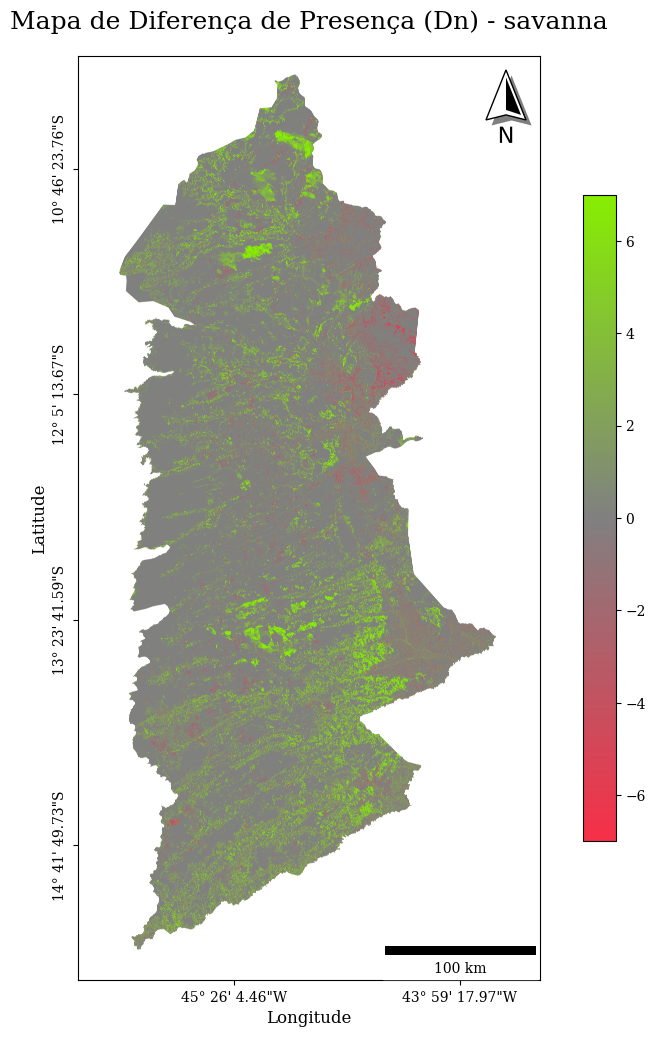

In [6]:
# =============================================================================
# NOVA CÉLULA: Mapa de Diferença de Presença Acumulada (Dn)
# =============================================================================
print("Iniciando a Célula de Geração de Mapa de Diferença de Presença (Dn).")

# =============================================================================
# 1. CÁLCULO DO MAPA 'Dn' (Lógica inalterada)
# =============================================================================

try:
    with rasterio.open(path_to_first_file) as src:
        profile = src.profile
        height, width = src.height, src.width
        Dn_map = np.zeros((height, width), dtype=np.float32)
        print(f"Mapa acumulador 'Dn' inicializado com dimensões: {height}x{width}.")
except NameError:
    print("ERRO: A célula anterior (mapa An) precisa ser executada primeiro para definir 'path_to_first_file'.")
    Dn_map = None

if Dn_map is not None:
    final_nodata_mask = np.ones_like(Dn_map, dtype=bool)
    for year in time_points:
        file_name = f"{class_name}{year}.tif"
        path_x = os.path.join(path_series_x, file_name)
        path_y = os.path.join(path_series_y, file_name)
        if os.path.exists(path_x) and os.path.exists(path_y):
            with rasterio.open(path_x) as src_x, rasterio.open(path_y) as src_y:
                array_x = src_x.read(1).astype(np.int64)
                array_y = src_y.read(1).astype(np.int64)
                difference_map = array_y - array_x
                valid_mask = (src_x.read(1) != nodata_value) & (src_y.read(1) != nodata_value)
                Dn_map[valid_mask] += difference_map[valid_mask]
                final_nodata_mask &= ~valid_mask
    Dn_map[final_nodata_mask] = nodata_value

# =============================================================================
# 2. SALVAR E EXIBIR O MAPA FINAL (COM AJUSTES FINAIS)
# =============================================================================

if Dn_map is not None:
    # --- Salva o arquivo GeoTIFF (lógica inalterada) ---
    output_filename_map_dn = f'map_Dn_presence_difference_{class_name}.tif'
    profile.update(dtype=rasterio.float32, nodata=nodata_value)
    print(f"✅\nSalvando o mapa final como: {output_filename_map_dn}")
    with rasterio.open(output_filename_map_dn, 'w', **profile) as dst:
        dst.write(Dn_map, 1)

    print("Gerando mapa...")
    
    # --- Preparação dos Dados e Metadados para o Mapa ---
    with rasterio.open(output_filename_map_dn) as src:
        bounds = src.bounds
        src_crs = src.crs
        transform = src.transform
        transformer = Transformer.from_crs(src_crs,
                                           "EPSG:4326",
                                           always_xy=True)
        data = src.read(1)
        # Mascara apenas o NoData. O valor 0 será tratado pelo mapa de cores.
        masked_map = np.ma.masked_equal(data, nodata_value)

    # --- Lógica de Cores Personalizada (Vermelho -> Cinza -> Azul) ---
    # Cria uma paleta de cores personalizada que tem o cinza no centro (valor 0)
    colors = ["#f72f47",
              "gray",
              "#87ee01"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_div_cmap", colors)
    
    # Define a cor para NoData (valores mascarados) como branco
    cmap.set_bad(color='white')
    
    # Encontra o valor absoluto máximo para centralizar a paleta de cores em 0
    max_abs_val = np.ma.max(np.abs(masked_map))
    norm = mcolors.Normalize(vmin=-max_abs_val, vmax=max_abs_val)

    # --- Funções para Formatar os Ticks (do template) ---
    def format_x_ticks(x, pos):
        lon, _ = transformer.transform(x, bounds.bottom)
        deg, min_val, sec = int(abs(lon)), int((abs(lon) - int(abs(lon))) * 60), (abs(lon) * 3600) % 60
        return f"{deg}° {min_val}' {sec:.2f}\"" + ("E" if lon >= 0 else "W")

    def format_y_ticks(y, pos):
        _, lat = transformer.transform(bounds.left, y)
        deg, min_val, sec = int(abs(lat)), int((abs(lat) - int(abs(lat))) * 60), (abs(lat) * 3600) % 60
        return f"{deg}° {min_val}' {sec:.2f}\"" + ("N" if lat >= 0 else "S")

    # --- Geração do Gráfico ---
    fig, ax = plt.subplots(figsize=(14, 12))
    mpl.rcParams['font.family'] = 'serif'
    
    # Plota o mapa com a paleta de cores personalizada
    im = ax.imshow(masked_map, cmap=cmap, norm=norm, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    
    ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    ax.tick_params(axis='x',
                   which='major',
                   labelsize=10, pad=4)
    ax.tick_params(axis='y',
                   which='major',
                   labelsize=10, pad=4)
    plt.setp(ax.get_yticklabels(),
             rotation=90,
             va='center')
    
    north_arrow(ax,
                location="upper right",
                rotation={"degrees": 0})
    
    # Add scale bar
    def km_to_degrees(value, dimension):
        approx_deg = value / 111  # Approximate conversion: 1° ≈ 111km
        return f"{approx_deg:.1f}°"

    scalebar = ScaleBar(
        1/1000,
        units='km',
        length_fraction=0.4,
        location='lower right',
        scale_formatter=lambda value, _: f"{int(value)} km"
    )
    ax.add_artist(scalebar)

    # --- Legenda de Barra de Cores (Ajustada) ---
    # Usa o parâmetro 'shrink' para diminuir o tamanho e remove a chamada 'set_label'
    cbar = fig.colorbar(im,
                        ax=ax,
                        orientation='vertical',
                        fraction=0.046,
                        pad=0.04,
                        shrink=0.7)
    
    # --- Ajustes Finais ---
    ax.set_aspect('equal')
    ax.set_title(f'Mapa de Diferença de Presença (Dn) - {class_name}',
                 fontsize=18,
                 pad=20)
    ax.set_xlabel('Longitude',
                  fontsize=12)
    ax.set_ylabel('Latitude',
                  fontsize=12)
    
    plt.show()

## Change Agreement

In [ ]:
# =============================================================================
# NOVA CÉLULA: Mapa de Dominância da Concordância de Mudança (Gain Hit vs Loss Hit)
# =============================================================================
print("✅ Iniciando a Célula de Geração do Mapa de Dominância da Concordância.")

# =============================================================================
# 1. CÁLCULO DOS MAPAS ACUMULADOS DE CONCORDÂNCIA
# =============================================================================

try:
    with rasterio.open(path_to_first_file) as src:
        profile = src.profile
        height, width = src.height, src.width
        # Inicializa dois mapas: um para a soma de Ghtn, outro para a soma de |Lhtn|
        Ghtn_sum_map = np.zeros((height, width), dtype=np.float32)
        Lhtn_sum_map = np.zeros((height, width), dtype=np.float32)
        print(f"Mapas acumuladores inicializados com dimensões: {height}x{width}.")
except NameError:
    print("ERRO: A célula do primeiro mapa (An) precisa ser executada para definir as variáveis.")
    Ghtn_sum_map = None

if Ghtn_sum_map is not None:
    print("\nCalculando a concordância de ganho e perda para cada intervalo...")
    final_nodata_mask = np.ones_like(Ghtn_sum_map, dtype=bool)

    for i in range(1, len(time_points)):
        year_t, year_t_minus_1 = time_points[i], time_points[i-1]
        print(f"Processando intervalo: {year_t_minus_1}-{year_t}...")
        
        array_x_t, array_y_t = get_raster_array(year_t)
        array_x_t_minus_1, array_y_t_minus_1 = get_raster_array(year_t_minus_1)
        if array_x_t is None: continue

        valid_mask = (array_x_t != nodata_value) & (array_y_t != nodata_value) & \
                     (array_x_t_minus_1 != nodata_value) & (array_y_t_minus_1 != nodata_value)
        
        change_x = np.subtract(array_x_t, array_x_t_minus_1, dtype=np.int16)
        change_y = np.subtract(array_y_t, array_y_t_minus_1, dtype=np.int16)
        gain_x, gain_y = np.maximum(0, change_x), np.maximum(0, change_y)
        loss_x, loss_y = np.minimum(0, change_x), np.minimum(0, change_y)
        
        Ghtn_map = np.minimum(gain_x, gain_y)
        Lhtn_map = np.maximum(loss_x, loss_y)
        
        np.add(Ghtn_sum_map, Ghtn_map, out=Ghtn_sum_map, where=valid_mask)
        # Subtraímos Lhtn (que é negativo) para somar sua magnitude
        np.subtract(Lhtn_sum_map, Lhtn_map, out=Lhtn_sum_map, where=valid_mask)
        
        final_nodata_mask &= ~valid_mask
            
    # Define NoData nos pixels que nunca foram válidos
    Ghtn_sum_map[final_nodata_mask] = nodata_value
    Lhtn_sum_map[final_nodata_mask] = nodata_value

# =============================================================================
# 2. CLASSIFICAÇÃO DO MAPA DE DOMINÂNCIA
# =============================================================================

if Ghtn_sum_map is not None:
    print("\nClassificando os pixels por dominância...")
    # Inicializa o mapa de classes. 1 será a classe 'Sem Concordância'.
    # Usamos uint8 pois teremos poucas classes.
    dominance_map = np.ones_like(Ghtn_sum_map, dtype=np.uint8)

    # Define as classes com base na comparação dos totais acumulados
    dominance_map = np.where(Ghtn_sum_map > Lhtn_sum_map, 2, dominance_map) # 2 = Ganho Dominante
    dominance_map = np.where(Lhtn_sum_map > Ghtn_sum_map, 3, dominance_map) # 3 = Perda Dominante
    dominance_map = np.where((Lhtn_sum_map == Ghtn_sum_map) & (Ghtn_sum_map > 0), 4, dominance_map) # 4 = Misto
    
    # Aplica a máscara de NoData ao mapa final
    dominance_map[Ghtn_sum_map == nodata_value] = 255 # Usando 255 para NoData
    
# =============================================================================
# 3. SALVAR E EXIBIR O MAPA FINAL
# =============================================================================

if 'dominance_map' in locals():
    output_filename_map_dom = f'map_Dominance_change_agreement_{class_name}.tif'
    profile.update(dtype=rasterio.uint8, nodata=255) # Atualiza perfil para o mapa de classes
    print(f"✅\nSalvando o mapa final como: {output_filename_map_dom}")
    with rasterio.open(output_filename_map_dom, 'w', **profile) as dst:
        dst.write(dominance_map, 1)

    print("Gerando mapa...")
    
    scale_factor = 0.15

    with rasterio.open(output_filename_map_dom) as src:
        bounds, src_crs, transform = src.bounds, src.crs, src.transform
        transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)
        data = src.read(1, out_shape=(int(src.height * scale_factor), int(src.width * scale_factor)), resampling=Resampling.nearest)
        masked_map = np.ma.masked_equal(data, 255)
    
    # --- Lógica de Cores e Legenda para as classes de dominância ---
    colors = {
        1: 'gray',          # Sem Concordância
        2: '#0070C0',        # Ganho Dominante (Azul)
        3: '#C00000',        # Perda Dominante (Vermelho)
        4: "#E5FC15"         # Misto (Roxo)
    }
    cmap = ListedColormap([colors[k] for k in sorted(colors.keys())])
    boundaries = sorted(colors.keys()) + [5] # Limites para as 4 classes
    norm = BoundaryNorm(boundaries, cmap.N)
    cmap.set_bad(color='white')

    def format_x_ticks(x, pos):
        lon, _ = transformer.transform(x, bounds.bottom)
        deg, min_val, sec = int(abs(lon)), int((abs(lon) - int(abs(lon))) * 60), (abs(lon) * 3600) % 60
        return f"{deg}° {min_val}' {sec:.2f}\"" + ("E" if lon >= 0 else "W")

    def format_y_ticks(y, pos):
        _, lat = transformer.transform(bounds.left, y)
        deg, min_val, sec = int(abs(lat)), int((abs(lat) - int(abs(lat))) * 60), (abs(lat) * 3600) % 60
        return f"{deg}° {min_val}' {sec:.2f}\"" + ("N" if lat >= 0 else "S")

    fig, ax = plt.subplots(figsize=(14, 12))
    mpl.rcParams['font.family'] = 'serif'
    
    im = ax.imshow(masked_map, cmap=cmap, norm=norm, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    
    ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks)); ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
    ax.xaxis.set_major_locator(plt.MaxNLocator(3)); ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    ax.tick_params(axis='x', which='major', labelsize=10, pad=4); ax.tick_params(axis='y', which='major', labelsize=10, pad=4)
    plt.setp(ax.get_yticklabels(), rotation=90, va='center')
    
    north_arrow(ax, location="upper right", rotation={"degrees": 0})
    scalebar = ScaleBar(1/1000, units='km', length_fraction=0.4, location='lower right', scale_formatter=lambda value, _: f"{int(value)} km")
    ax.add_artist(scalebar)

    labels_legenda = [
        'Sem Concordância de Mudança',
        'Ganho Dominante',
        'Perda Dominante',
        'Concordância Mista (Ganho = Perda)'
    ]
    patches = [mpatches.Patch(color=colors[i+1], label=labels_legenda[i]) for i in range(len(labels_legenda))]
    ax.legend(handles=patches, title='Dominância da Concordância de Mudança', loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, fontsize=12)
    
    ax.set_aspect('equal')
    ax.set_title(f'Mapa de Dominância da Concordância - {class_name}', fontsize=18, pad=20)
    ax.set_xlabel('Longitude', fontsize=12); ax.set_ylabel('Latitude', fontsize=12)
    
    plt.show()

✅ Iniciando a Célula de Geração do Mapa de Dominância da Concordância.
Mapas acumuladores inicializados com dimensões: 20480x10240.

Calculando a concordância de ganho e perda para cada intervalo...
Processando intervalo: 1990-1995...
Processando intervalo: 1995-2000...


## Change Difference